In [1]:
import cv2
import torch
import os
import random
import math
import glob 
import pathlib
import csv, PIL
import time, zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from os import listdir
from torchvision import*

%matplotlib inline

In [80]:
df = pd.read_csv('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv.csv')
df

,path,Filename,origin_filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,Label
0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,Cov_combatting_Image1,Cov_combatting_Image1.mp4,Cov_combatting_Image1_frame_003.jpg,0,0,1,1,COVID-19
1,/home/Sean/PoCOVID/4real/covid20_pocus_ultraso...,Cov_combatting_Image1,Cov_combatting_Image1.mp4,Cov_combatting_Image1_frame_006.jpg,0,0,1,1,COVID-19
2,/home/Sean/PoCOVID/4real/covid21_pocus_ultraso...,Cov_combatting_Image1,Cov_combatting_Image1.mp4,Cov_combatting_Image1_frame_009.jpg,0,0,1,1,COVID-19
3,/home/Sean/PoCOVID/4real/covid22_pocus_ultraso...,Cov_combatting_Image1,Cov_combatting_Image1.mp4,Cov_combatting_Image1_frame_012.jpg,0,0,1,1,COVID-19
4,/home/Sean/PoCOVID/4real/covid23_pocus_ultraso...,Cov_combatting_Image1,Cov_combatting_Image1.mp4,Cov_combatting_Image1_frame_015.jpg,0,0,1,1,COVID-19
...,...,...,...,...,...,...,...,...,...
7247,/home/Sean/PoCOVID/4real/covid7266_pocus_ultra...,Reg-Grep-Normal,Reg-Grep-Normal.gif,Reg-Grep-Normal_frame_021.jpg,0,0,0,1,regular
7248,/home/Sean/PoCOVID/4real/covid7267_pocus_ultra...,Reg-Grep-Normal,Reg-Grep-Normal.gif,Reg-Grep-Normal_frame_024.jpg,0,0,0,1,regular
7249,/home/Sean/PoCOVID/4real/covid7268_pocus_ultra...,Reg-Grep-Normal,Reg-Grep-Normal.gif,Reg-Grep-Normal_frame_027.jpg,0,0,0,1,regular
7250,/home/Sean/PoCOVID/4real/covid7269_pocus_ultra...,Reg-Grep-Normal,Reg-Grep-Normal.gif,Reg-Grep-Normal_frame_030.jpg,0,0,0,1,regular


In [81]:
aa = df.iloc[:,4:8]
aa

,Effusion,Consolidations,B-lines,Healthy
0,0,0,1,1
1,0,0,1,1
2,0,0,1,1
3,0,0,1,1
4,0,0,1,1
...,...,...,...,...
7247,0,0,0,1
7248,0,0,0,1
7249,0,0,0,1
7250,0,0,0,1


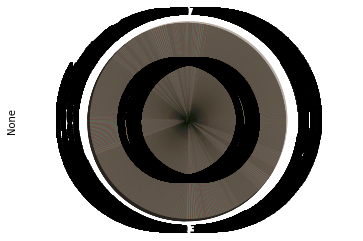

In [71]:
fig1, ax1 = plt.subplots()
df.iloc[:,4:8].sum(axis=1).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

Vir_blines_advancesVid9_frame_117.jpg


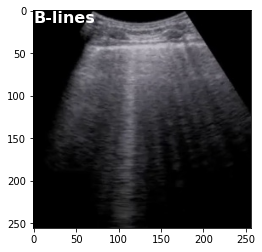

In [83]:
classLabels = ["Effusion", "Consolidations", "B-lines", "Healthy"]
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd.converted_filename
    label = fd[4:8].tolist()
    print(image)
    try:
        image = Image.open("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"+image)
    except:
        pass 
    
    fig,ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()
    
visualizeImage(605)

## Model


In [158]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

from pathlib import Path
from torch.utils.data import Dataset, DataLoader ,random_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"'{device}' is avilable.")

'cuda' is avilable.


In [170]:
class MyDataset(Dataset):
    def __init__(self , csv_file , img_dir , transforms=None ):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transforms = transforms
    def __getitem__(self,idx):
        d = self.df.iloc[idx.item()]
        image = Image.open(self.img_dir/d.image).convert("RGB")
        label = torch.tensor(d[4:8].tolist() , dtype=torch.float32)
        
        if self.transforms is not None:
            image = self.transforms(image)
        return image,label
    
    def __len__(self):
        return len(self.df)

In [171]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = MyDataset("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv.csv" ,
                    Path("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg") , transform)
valid_no = int(len(dataset)*0.12) 

trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])

print(f"trainset len {len(trainset)} valset len {len(valset)}")

dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 6382 valset len 870


In [172]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)

2048


In [173]:
for param in model.parameters():
    param.requires_grad_(False)

In [174]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer

#model

In [175]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss() # 이게 멀티레이블 해주는거임 꼭 기억해두셈

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [176]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):
    for epoch in trange(num_epochs,desc="Epochs"):
        result = []
        for phase in ['train', 'val']:
            if phase=="train":     # put the model in training mode
                model.train()
                scheduler.step()
            else:     # put the model in validation mode
                model.eval()
       
            # keep track of training and validation loss
            running_loss = 0.0
            running_corrects = 0.0  
            
            for data , target in data_loader[phase]:
                #load the data and target to respective device
                data , target = data.to(device)  , target.to(device)
                
                with torch.set_grad_enabled(phase=="train"):
                    #feed the input
                    output = model(data)
                    #calculate the loss
                    loss = criterion(output,target)
                    preds = torch.sigmoid(output).data > 0.5
                    preds = preds.to(torch.float32)
                    
                    if phase=="train"  :
                        # backward pass: compute gradient of the loss with respect to model parameters 
                        loss.backward()
                        # update the model parameters
                        optimizer.step()
                        # zero the grad to stop it from accumulating
                        optimizer.zero_grad()
                        
                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects / len(data_loader[phase].dataset)
            
            result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print(result)

In [177]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'item'